## N-Qubit Boltzmann Machine

We use a n-qubit system, where the goal is to learn the parameters of the Ising Hamiltonian:

$H = \sum_{i} \sum_{j}\sum_{k} \sum_{k'} w_{ij}^{kk'} \sigma_i^k \otimes \sigma_j^{k'} + \sum_{i}\sum_{k} h^k_i \sigma_{i}^k$

where $w_{ij}^{kk'}$ is the coupling strength, $h_i$ are the local fields, and $\sigma_i^k$ are the Pauli operators. For the Pauli matrices, indexes $k=1,2,3$ correspond to $x,y,z$, index $k=0$ to the identity. The explicit Hamiltonian is written as:

$H = \sum_{k} \sum_{k'} w_{ij}^{kk'} \sigma_0^k \otimes \sigma_1^{k'} + h^k_0 \sigma_0^k \otimes \sigma_1^0 + h^{k'}_1 \sigma_0^0 \otimes \sigma_1^{k'}$

A vector state follows the numbering convention $|s_0, \dots, s_n>$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from numba import njit
from itertools import product
from scipy.linalg import kron

In [12]:
@njit
def expmat(A):
    """
    Computes the exponential of a given matrix `A'.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex64)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.exp(evals[i]) * projector
    return res

@njit
def logmat(A):
    """
    Computes the natural logarithm of a given matrix `A`.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex64)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector)
        res += np.log(evals[i]) * projector
    return res

def generate_interaction_matrices(num_qubits):
    """
    Constructs the tensor product of Pauli matrices for each spin and 
    uses them to build the interaction matrices between the spins
    """
    pauI = np.array([[1,0],[0,1]],np.complex64)
    pauX = np.array([[0,1],[1,0]],np.complex64)
    pauY = np.array([[0,-1j],[1j,0]],np.complex64)
    pauZ = np.array([[1,0],[0,-1]],np.complex64)
    pau = np.array([pauI, pauX, pauY, pauZ], dtype=np.complex64)
    
    interactions = []                                   # initialize a list to store the interaction matrices
    for matrix_pair in product(pau, repeat=num_qubits): # loop through all possible combinations of Pauli matrices of length num_qubits
        interaction_matrix = matrix_pair[0]             # the first matrix in the current combination
        for matrix in matrix_pair[1:]:                  # compute the tensor product for rest of the matrices in the current combination
            interaction_matrix = kron(interaction_matrix, matrix)
        interactions.append(interaction_matrix)         # append the computed tensor product to the list of interaction matrices
    return np.array(interactions, dtype=np.complex64)   # convert interactions list to a NumPy array for better numba 

@njit
def hamiltonian_n_qubits(w, interactions, num_qubits):
    """
    Calculates the Hamiltonian matrix of an n-qubit system
    """
    H = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex64)
    for i in range(len(w)):
        H += w[i] * interactions[i]

    return H

@njit
def rho_model(w, interactions, num_qubits):
    """
    Computes the density matrix of an n-qubit system using the Hamiltonian
    and the interaction matrices, and then normalizes it. Exact Diagonalization.
    """
    H = hamiltonian_n_qubits(w, interactions, num_qubits)  # get Hamiltonian matrix
    rho = expmat(H)                                        # definition of rho
    Z = np.real(np.trace(rho))                             # get Z
    rho /= Z                                               # normalize such that Tr[rho] = 1
    return rho 

@njit
def observables(rho, interactions, num_qubits):
    """
    Computes the expectation values of the interaction matrices [observables]
    """
    obs = np.zeros(len(interactions), dtype=np.complex64)
    for i, interaction_matrix in enumerate(interactions):
        rho_contig = np.ascontiguousarray(rho)                                    # make rho and interaction matrices contiguious for numba
        interaction_matrix_contig = np.ascontiguousarray(interaction_matrix)
        obs[i] = np.real(np.trace(np.dot(rho_contig, interaction_matrix_contig))) # compute the expectation value for the current interaction matrix
    return obs

@njit
def KL_divergence(eta,rho):
    """
    Calculates the KL divergence between the model and target distribution.
    """
    return np.real(np.trace(eta@(logmat(eta)-logmat(rho))))

In [59]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot_scatter(ax, x, y, xlabel, ylabel, color, size=10):
    '''Creates a scatter subplot'''
    ax.scatter(x, y, s=size, marker='o', color=color)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    # ax.set_yscale('log')

def plot(it, KL, Wmax, title='Convergence Plots', size=10):
    fig = plt.figure(figsize=(25, 6));                           #  make plots
    fig.suptitle(title, fontsize=30, y = 1)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    its= np.arange(1,it+1,1)

    ax1 = fig.add_subplot(1, 2, 1)
    plot_scatter(ax1, its, Wmax[:it], "Iterations", r"$ (\Delta W)_{max}$", "Coral", size)
    ax1.text(0, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
   
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(its, KL[:it], s=size, marker='o', color="ForestGreen")
    ax2.set_xlabel("Iterations", fontsize=20)
    ax2.set_ylabel("KL Divergence", fontsize=20)
    ax2.text(0, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

In [60]:
@njit
def generate_w(random_seed, num_qubits):
    """
    Generates a random parameter matrix w for the random seed value random_seed.
    """
    np.random.seed(random_seed)        # set the random seed value
    num_params = 4**num_qubits      # calculate the number of parameters for the weight matrix
    w = np.random.rand(num_params)  # generate a random parameter matrix w of size num_params
    w[0] = 0

    return w

@njit
def learn_w(interactions, learning_rate, maxiter, tolerance, random_seed, num_qubits):
    """
    Train the model to fit the target distribution eta.
    """
    w_eta = generate_w(random_seed, num_qubits)  # get initial weights for clamped QM statistics
    eta = rho_model(w_eta, interactions, num_qubits)  # generate the target density matrix eta
    obs_clamped = observables(eta, interactions, num_qubits)  # get clamped QM statistics

    w = generate_w(random_seed + 1, num_qubits)  # get initial weights for free QM statistics
    rho = rho_model(w, interactions, num_qubits)  # generate the density matrix rho for the initial weights
    obs_model = observables(rho, interactions, num_qubits)  # get free QM statistics

    it = 0  # initialize gradient ascent loop
    diff = np.max(np.abs(obs_model - obs_clamped))
    Wmax_list = np.zeros(maxiter)  # initialize values to store
    KL_list = np.zeros(maxiter)

    while (diff > tolerance and it < maxiter):
        rho = rho_model(w, interactions, num_qubits)  # get free QM statistics
        obs_model = observables(rho, interactions, num_qubits)
        w += learning_rate * np.real(obs_clamped - obs_model)  # Update weights

        diff = np.max(np.abs(obs_model - obs_clamped))  # evaluate differences in clamped and model statistics
        Wmax = np.max(np.abs(w - w_eta))

        Wmax_list[it] = Wmax  # store values
        KL_list[it] = KL_divergence(eta, rho)
        it += 1

    return w, w_eta, KL_list, Wmax_list, it


# Results 2-qubit system

In [24]:
#learning parameters
learning_rate  = 0.7      #  learning rate 
maxiter        = 2**18    #  iterations
tolerance      = 1e-10    #  tolerance
random_seed    = 5555
num_qubits     = 2

interactions     = generate_interaction_matrices(num_qubits)     #  generate interaction matrices

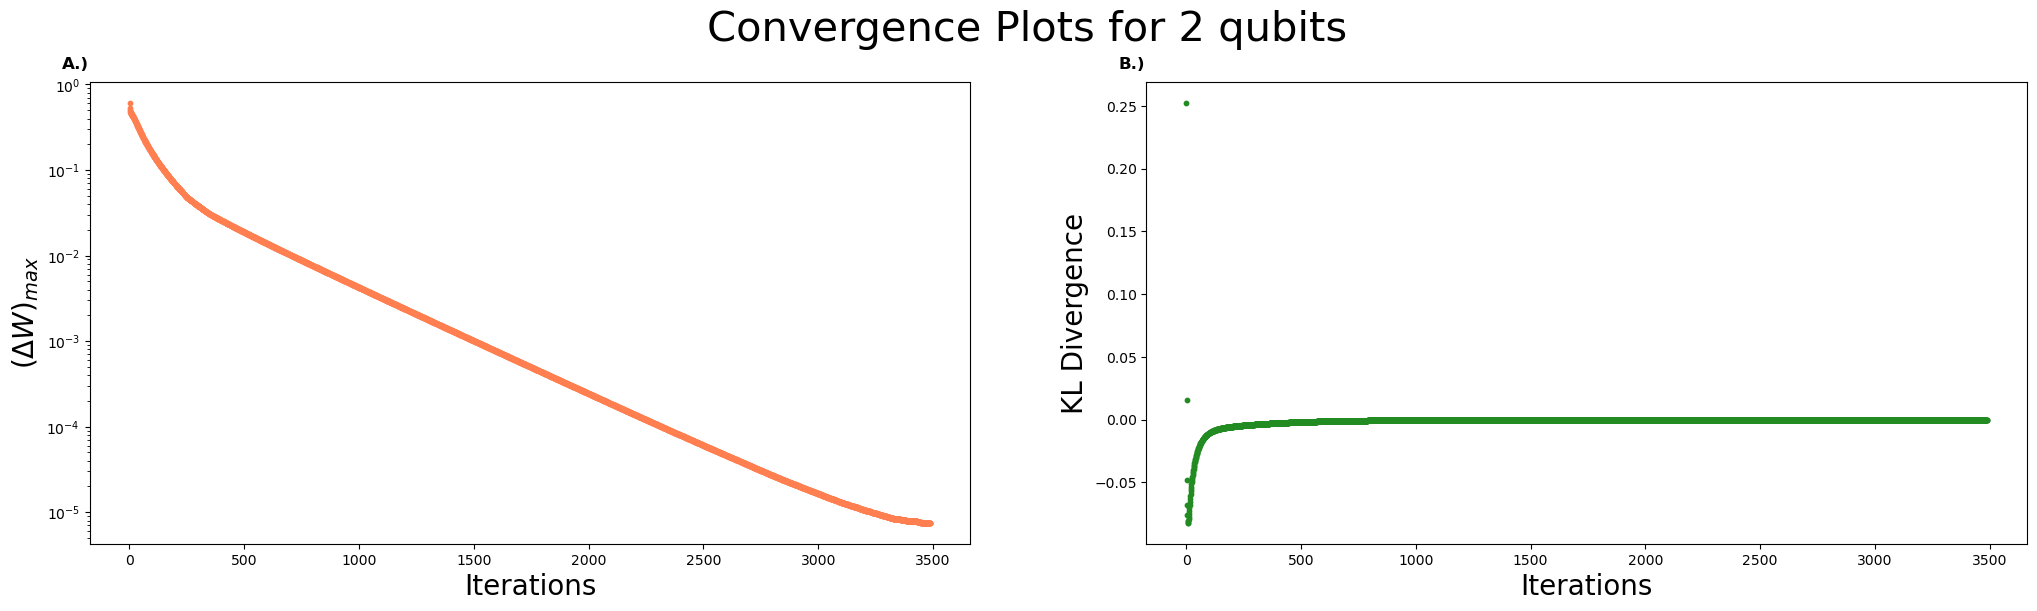

In [26]:
w, w_eta, KL, Wmax, it = learn_w(interactions, learning_rate, maxiter, tolerance, random_seed, num_qubits)
plot(it, KL, Wmax, title=f'Convergence Plots for {num_qubits} qubits', size=10)
plt.savefig('Figures/N Qubit QBM/convergence', bbox_inches='tight')

In [27]:
np.set_printoptions(formatter={'float_kind':"{:.6f}".format}) # print matrices in 2 decimals
#np.set_printoptions(formatter={'complex_kind': lambda x: "{:.2f}+{:.2f}j".format(x.real, x.imag)})

print(np.abs(w-w_eta))

[0.000003 0.000008 0.000006 0.000003 0.000005 0.000000 0.000003 0.000003
 0.000003 0.000007 0.000001 0.000002 0.000006 0.000000 0.000005 0.000000]


# Results 3-qubit system

In [61]:
#learning parameters
learning_rate = 0.1    #  learning rate 
maxiter  = 200         #  iterations
tolerance = 1e-10      #  tolerance
random_seed = 555
num_qubits = 6

interactions     = generate_interaction_matrices(num_qubits)     #  generate interaction matrices

In [62]:
interactions     = generate_interaction_matrices(6)     #  generate interaction matrices]
print(interactions.shape)

(4096, 64, 64)


[0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000

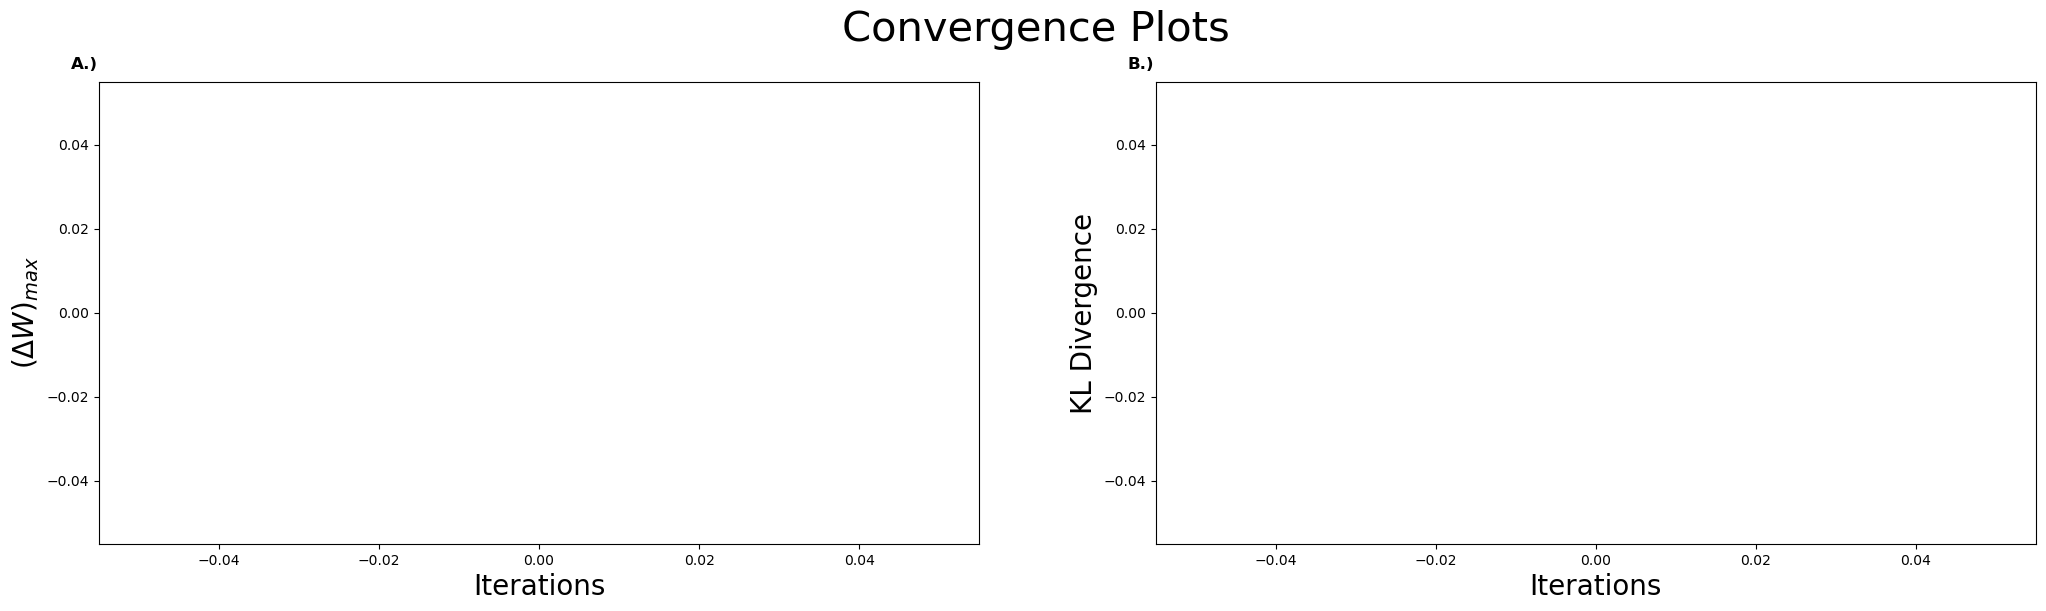

In [66]:
w, w_eta, KL, Wmax, it = learn_w(interactions, learning_rate, maxiter, tolerance, random_seed, num_qubits)
plot(it, KL, Wmax, title='Convergence Plots', size=10)
plt.savefig('Figures/N Qubit QBM/convergence', bbox_inches='tight')
print(Wmax)

In [65]:
np.set_printoptions(formatter={'float_kind':"{:.6f}".format}) # print matrices in 2 decimals
#np.set_printoptions(formatter={'complex_kind': lambda x: "{:.2f}+{:.2f}j".format(x.real, x.imag)})

print(np.abs(w-w_eta))

[0.000000 0.223558 0.165477 ... 0.170998 0.243288 0.043267]


# Results 4-Qubit system

In [88]:
#learning parameters
learning_rate       = 0.5      #  learning rate 
maxiter  = 2**16    #  iterations
tolerance      = 1e-10    #  tolerance
random_seed = 555
num_qubits = 4

interactions     = generate_interaction_matrices(num_qubits)     #  generate interaction matrices

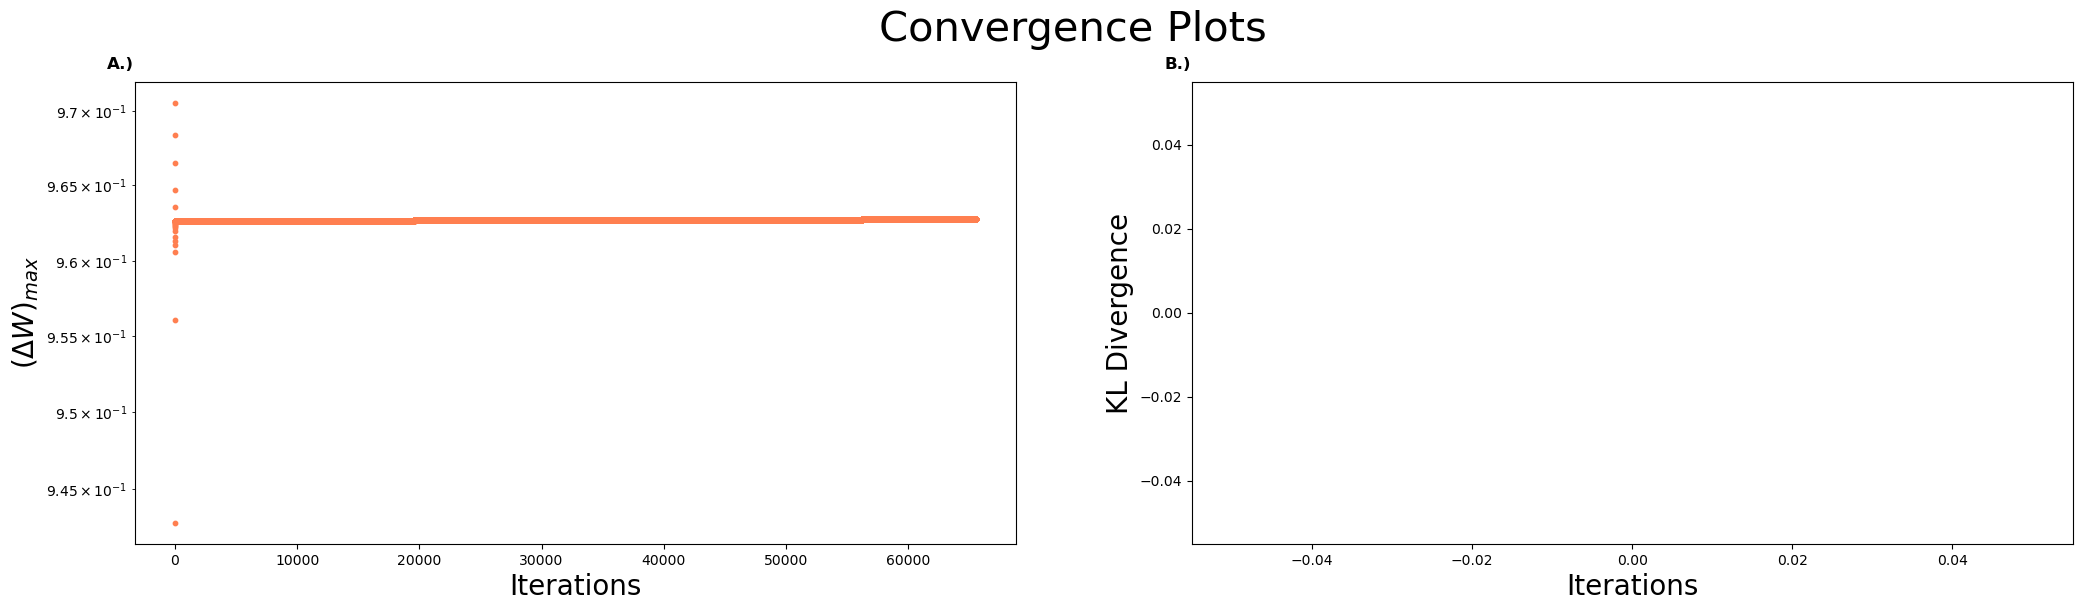

In [89]:
w, w_eta, KL, Wmax, it = learn_w(interactions, learning_rate, maxiter, tolerance, eta_seed, num_qubits)
plot(it, KL, Wmax, title='Convergence Plots', size=10)
plt.savefig('Figures/N Qubit QBM/convergence', bbox_inches='tight')

In [90]:
np.set_printoptions(formatter={'float_kind':"{:.6f}".format}) # print matrices in 2 decimals
#np.set_printoptions(formatter={'complex_kind': lambda x: "{:.2f}+{:.2f}j".format(x.real, x.imag)})

print(np.abs(w-w_eta))

[0.112295 0.022063 0.128840 0.179540 0.330918 0.089803 0.562717 0.068796
 0.343794 0.183620 0.747777 0.243946 0.119658 0.009615 0.333450 0.422969
 0.551156 0.135979 0.364152 0.516681 0.288394 0.221571 0.294054 0.234360
 0.395467 0.674056 0.283966 0.110514 0.124855 0.029882 0.954834 0.426622
 0.511561 0.019098 0.413521 0.253690 0.414202 0.428180 0.106245 0.027359
 0.199534 0.017626 0.204548 0.121323 0.246824 0.640509 0.392209 0.224511
 0.498679 0.322856 0.291160 0.456434 0.581694 0.020992 0.089214 0.246321
 0.033178 0.502518 0.300229 0.003052 0.039287 0.826940 0.942822 0.286689
 0.344802 0.520993 0.559108 0.267343 0.083867 0.086640 0.585918 0.708787
 0.138694 0.065913 0.169761 0.136119 0.005945 0.216303 0.662688 0.256933
 0.595318 0.407258 0.304179 0.228119 0.217103 0.479267 0.290732 0.178448
 0.190349 0.126480 0.019999 0.007868 0.068202 0.429773 0.295703 0.027722
 0.072335 0.696407 0.778220 0.595639 0.057409 0.152318 0.463079 0.188889
 0.693526 0.120222 0.449641 0.779170 0.588625 0.407

# Test ground

In [ ]:
def generate_w(wx1x2, wy1y2, w1z2z, hx1, hx2, hy1, hy2, hz1, hz2):
    return np.array([
        [0,  hx2, hy2, hz2],
        [hx1, wx1x2, 0,  0],
        [hy1, 0,  wy1y2, 0],
        [hz1, 0,  0,  w1z2z]
    ])

#interaction parameters
wx1x2 = 0
wy1y2 = 0
wz1z2 = 2
hx1   = 0
hx2   = 0
hy1   = 0
hy2   = 0
hz1   = 1
hz2   = 1
    
w = generate_w(wx1x2 ,wy1y2, wz1z2, hx1, hx2, hy1, hy2, hz1, hz2)

interactions is a list object containing all interaction matrices. For a 3-qubit system it would look something like this:

(I, I, I) -> I ⊗ I ⊗ I  
(I, I, X) -> I ⊗ I ⊗ X  
(I, I, Y) -> I ⊗ I ⊗ Y  
(I, I, Z) -> I ⊗ I ⊗ Z  
(I, X, I) -> I ⊗ X ⊗ I  
(I, X, X) -> I ⊗ X ⊗ X  
(I, X, Y) -> I ⊗ X ⊗ Y  
(I, X, Z) -> I ⊗ X ⊗ Z  
(I, Y, I) -> I ⊗ Y ⊗ I  
(I, Y, X) -> I ⊗ Y ⊗ X  
(I, Y, Y) -> I ⊗ Y ⊗ Y  
(I, Y, Z) -> I ⊗ Y ⊗ Z  
...  
